<a href="https://colab.research.google.com/github/JeanFirmino/PREVISAO-DO-PRE-O-DE-ACOES/blob/main/Aplica%C3%A7%C3%A3o_de_machine_learning_para_a_predi%C3%A7%C3%A3o_do_pre%C3%A7o_de_fechamento_de_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# como critério de seleção das ações, foi utilizado as séries históricas de empresas com pelo menos 20 anos de história
# na bolsa de valores do brasil, que tenham também os maiores volumes de movimentação atualmente (dezembro de 2020)

### Analise dos dados da ação OIBR3

Importando bibliotecas

In [ ]:
# Iniciando as bibliotecas usadas para montar um sistema de aprendizado de máquina, conhecido como "árvore de decisão",
# Tem como objetivo criar um "raciocínio" das informações de saída e entrada para que possa fornecer um método no qual seja possivel prever informações.
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Os dados foram coletados do site Br investing, teve como critério principal coletar os dados diários entre 01/01/1993 até 01/12/2020
# porém foi possivel encontrar registros até 14/01/2000.
# Para o estudo foi IMPORTANTE manipular os dados coletados, primeiro foi mantido a coluna preço e as datas em seu lugar de inicio,
# mas para os demais dados foi selecionado e "rebaixado", para que os dados do dia ficassem a par com as informações de abertura, max, min, vol e var 
# do pregão anterior, ou seja, temos como premissa que o valor de fechamento de hoje será influenciado pelos dados de abertura, max, min, vol e var do pregão anterior
origem = 'drive/My Drive/Artigo_de_economia,_programacao_e_matematica/oibrcomosdadoscertosparamanipulacao.csv'
planilha = pd.read_csv(origem, sep=':')
plt.style.use('classic')

In [ ]:
planilha.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,1,12,2020,2.11,2.10,2.17,2.07,173990000.0,3.41
1,30,11,2020,2.12,2.13,2.14,2.05,125870000.0,-1.44
2,27,11,2020,2.05,2.02,2.15,2.00,331690000.0,5.05
3,26,11,2020,2.08,1.86,1.98,1.84,157500000.0,6.45
4,25,11,2020,1.98,1.92,1.95,1.86,134140000.0,-2.11


In [ ]:
dados = planilha.dropna(axis=0, how='any') # Remover qualquer linhas que possua NaN (células vazias)

In [ ]:
dados.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,1,12,2020,2.11,2.10,2.17,2.07,173990000.0,3.41
1,30,11,2020,2.12,2.13,2.14,2.05,125870000.0,-1.44
2,27,11,2020,2.05,2.02,2.15,2.00,331690000.0,5.05
3,26,11,2020,2.08,1.86,1.98,1.84,157500000.0,6.45
4,25,11,2020,1.98,1.92,1.95,1.86,134140000.0,-2.11


In [ ]:
dados.shape

(4679, 9)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4679 entries, 0 to 4678
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dia       4679 non-null   int64  
 1   meses     4679 non-null   int64  
 2   anos      4679 non-null   int64  
 3   ultimo    4679 non-null   float64
 4   abertura  4679 non-null   float64
 5   maxima    4679 non-null   float64
 6   minima    4679 non-null   float64
 7   vol       4679 non-null   float64
 8   var       4679 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 365.5 KB


In [ ]:
dados["var"].value_counts().sort_index()

-97.34     1
-84.82     1
-36.04     1
-27.00     1
-23.49     1
          ..
 27.07     1
 29.09     1
 30.58     1
 35.94     1
 924.27    1
Name: var, Length: 1418, dtype: int64

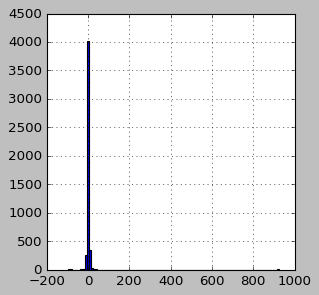

In [ ]:
dados["var"].hist(bins = 100, figsize = (4,4))

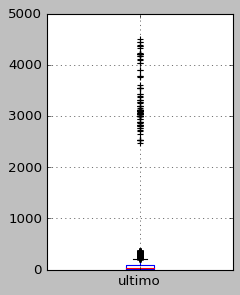

In [ ]:
dados.boxplot(figsize=(3, 4),column=['ultimo'])

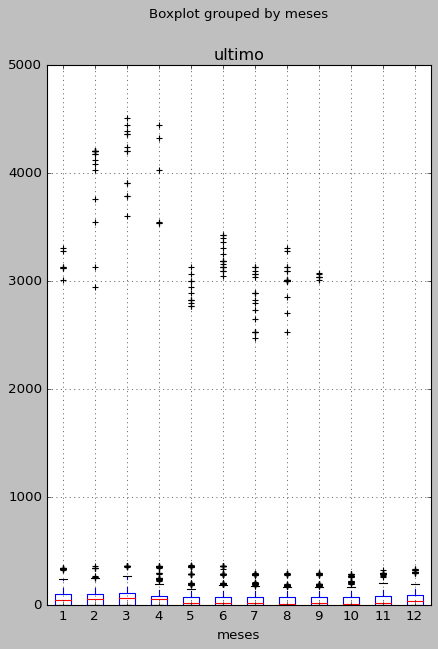

In [ ]:
dados.boxplot(figsize=(6, 9),column=['ultimo'],by = 'meses')

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xticks(fontsize = 16)
    plt.legend()
    plt.xlabel("Time")
    plt.yticks(fontsize = 16)
    plt.ylabel("Value")
    plt.grid(True)    

No handles with labels found to put in legend.


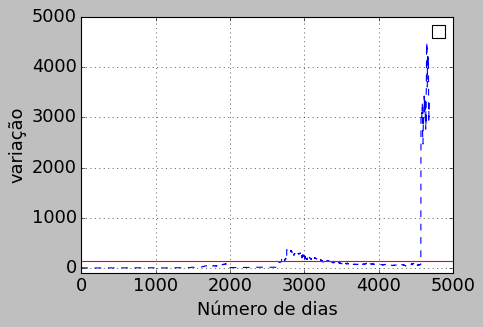

In [ ]:
plt.figure(figsize=(6, 4))
plot_series(np.linspace(1,len(dados),len(dados)),dados.ultimo,'--')
plt.xlabel("Número de dias", fontsize = 16)
plt.ylabel("variação", fontsize = 16)
plt.ylim(-100,)
plt.axhline(y=dados.ultimo.mean(), c = 'r')

In [ ]:
dados["ultimo"].mean() # média simples

137.7074887796536

In [ ]:
dados["ultimo"].std() # Retorna o desvio padrão da amostra sobre o eixo solicitado

513.2597876984256

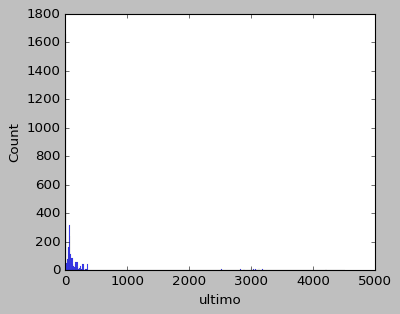

In [ ]:
plt.figure(figsize=(5,4))
sns.histplot(dados, x = "ultimo")

Aplicando o teste de correlação

In [ ]:
dados.columns.values

array(['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima',
       'vol', 'var'], dtype=object)

In [ ]:
dadostestes = ['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima','vol', 'var']
dadostestes = dados[dadostestes]

<Figure size 800x800 with 0 Axes>

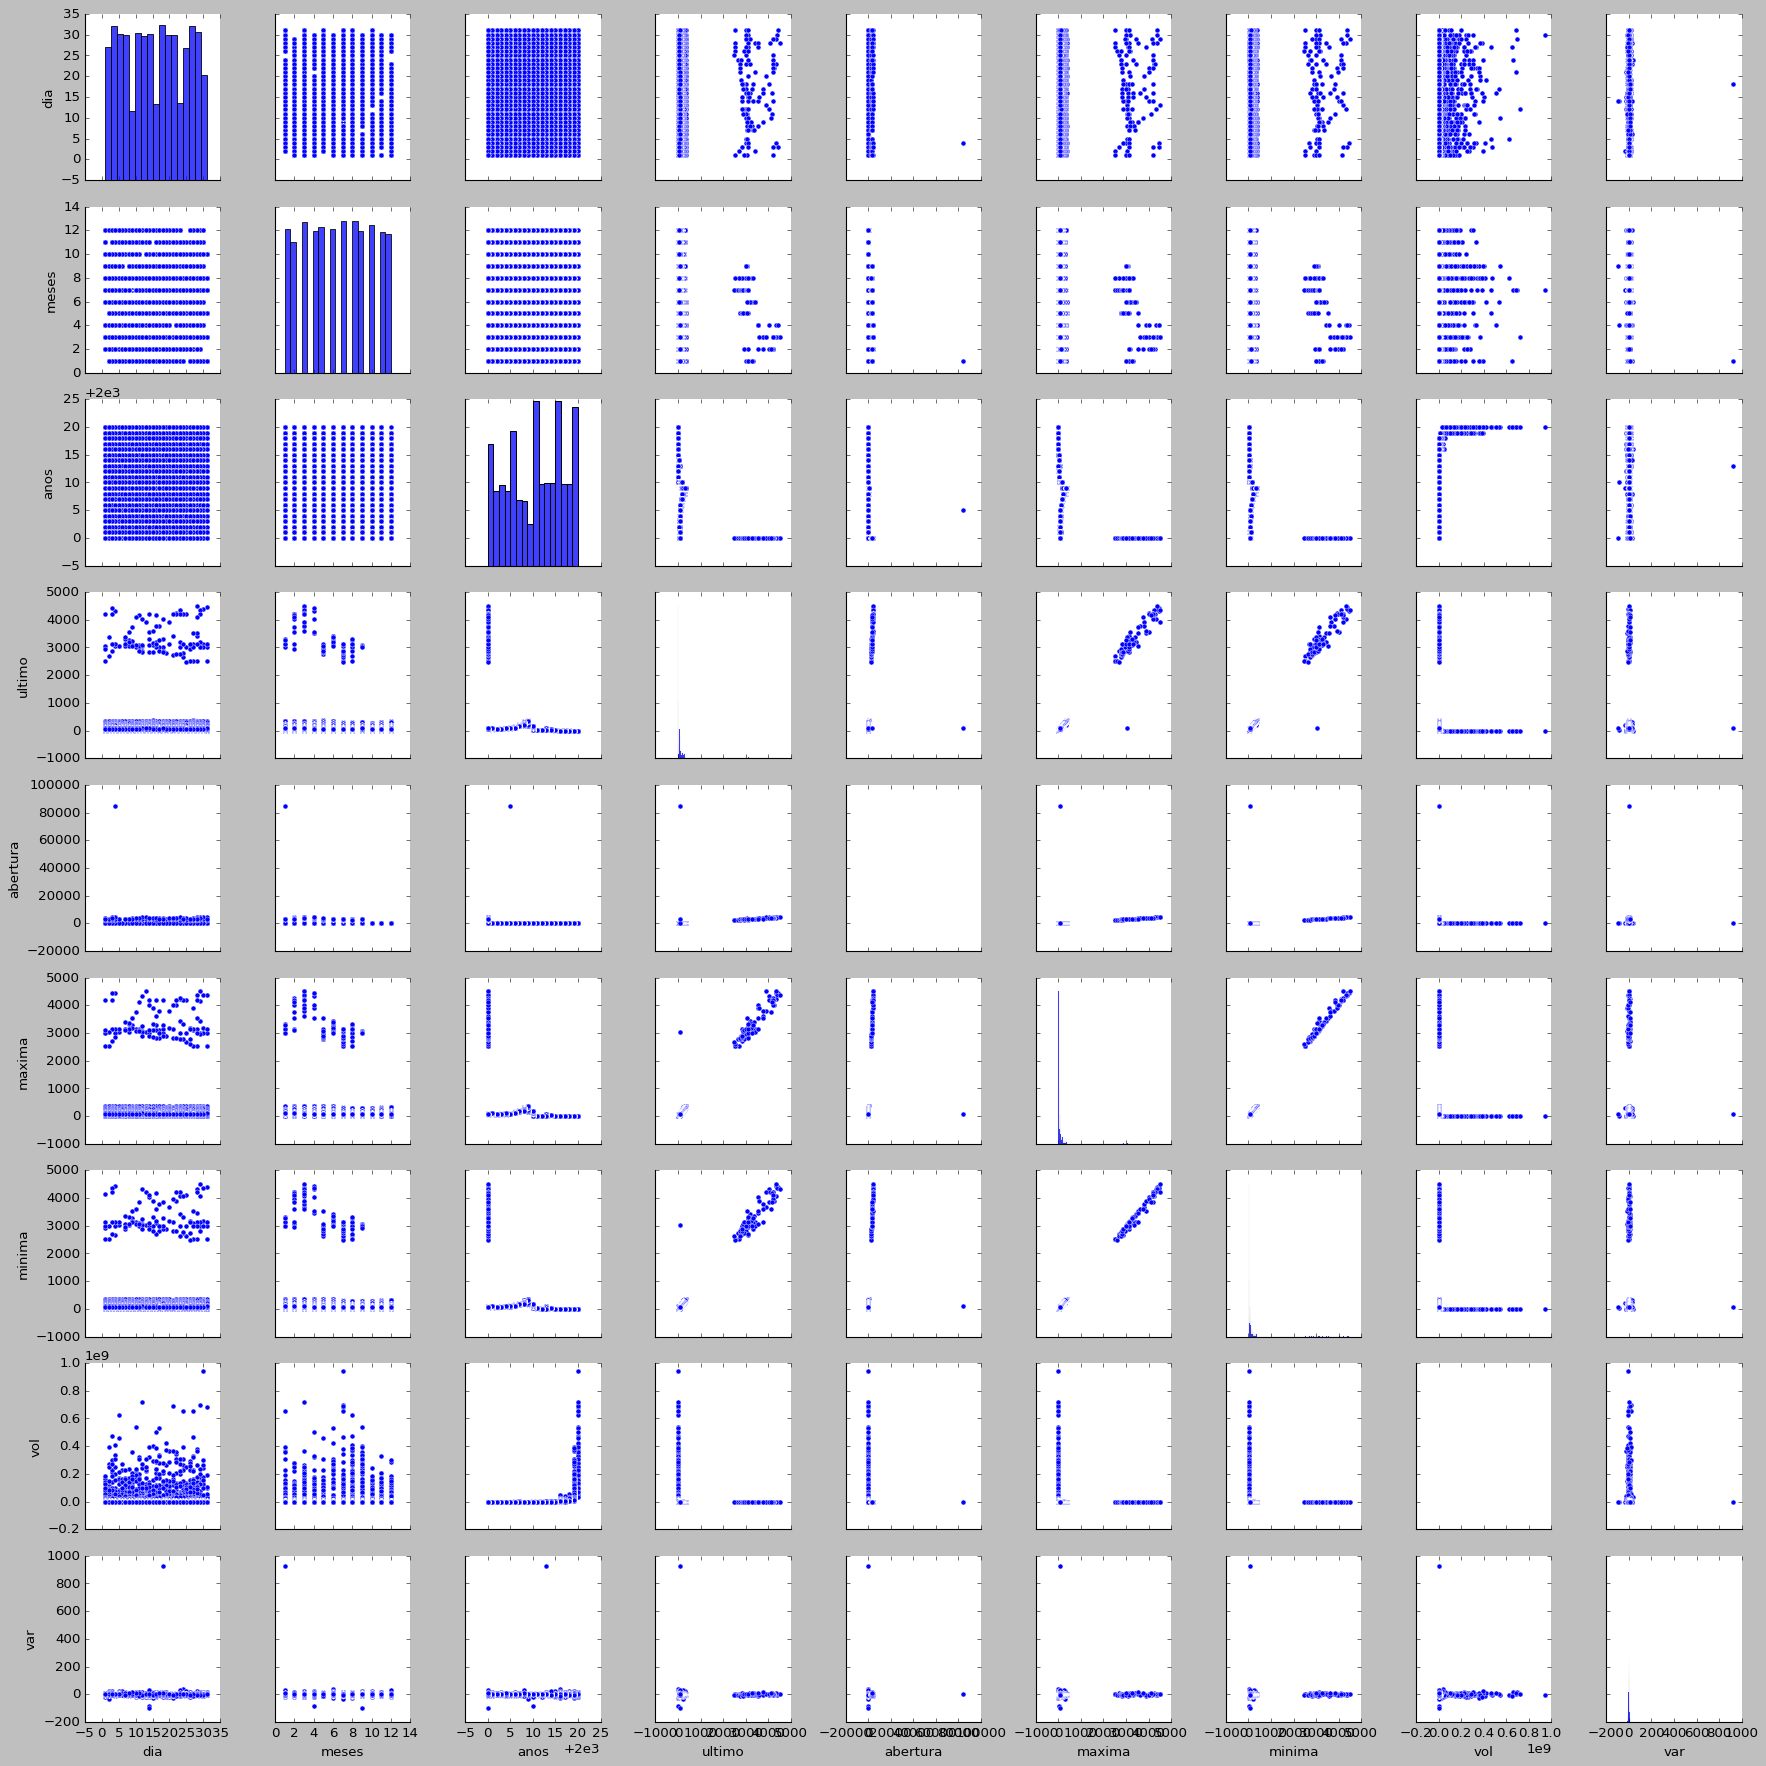

In [ ]:
plt.figure(figsize=(10, 10))
sns.pairplot(dadostestes)

In [ ]:
correlacao = dadostestes.corr()
correlacao

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
dia,1.000000,-0.006474,-0.005094,0.015999,-0.012070,0.015811,0.016009,0.014974,-0.001389
meses,-0.006474,1.000000,-0.029618,-0.077516,-0.050840,-0.076228,-0.075651,0.011323,-0.021452
anos,-0.005094,-0.029618,1.000000,-0.337392,-0.142033,-0.338288,-0.338368,0.386300,0.005163
ultimo,0.015999,-0.077516,-0.337392,1.000000,0.380251,0.995254,0.994842,-0.068766,0.003893
abertura,-0.012070,-0.050840,-0.142033,0.380251,1.000000,0.382218,0.382314,-0.029949,0.001195
maxima,0.015811,-0.076228,-0.338288,0.995254,0.382218,1.000000,0.999637,-0.068944,0.002880
minima,0.016009,-0.075651,-0.338368,0.994842,0.382314,0.999637,1.000000,-0.068835,0.002608
vol,0.014974,0.011323,0.386300,-0.068766,-0.029949,-0.068944,-0.068835,1.000000,0.009447
var,-0.001389,-0.021452,0.005163,0.003893,0.001195,0.002880,0.002608,0.009447,1.000000


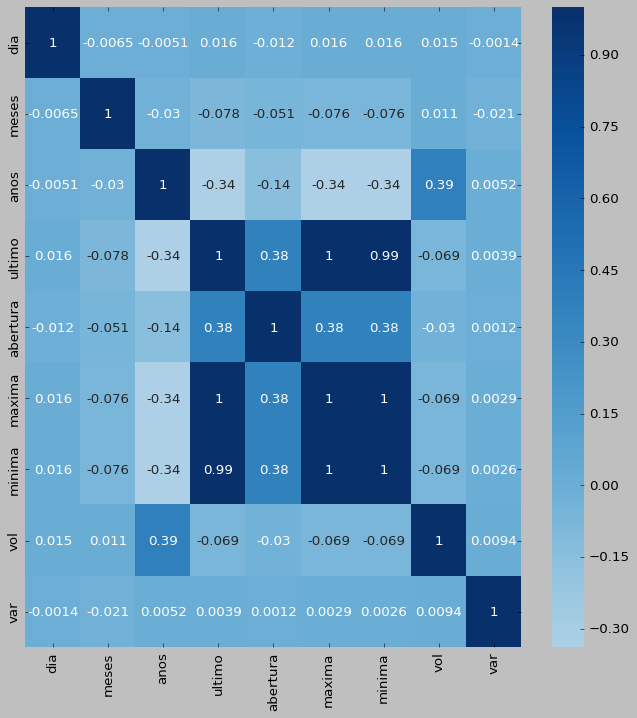

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlacao, cmap="Blues", center=0, annot=True)

Normalizando os dados de fechamento

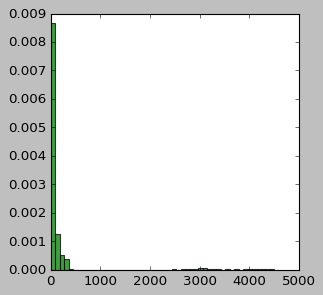

Média dos valores normalizados 2.6185769740354123
Desvio Padrão dos valores normalizados 1.610727577869304


In [ ]:
series = dados.ultimo
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()
iteração = np.linspace(1,len(dados),len(dados))
percent_train = .7
divisao = int(percent_train*len(dados))
ln_series = np.log(series+1)
x_train = ln_series[:divisao]
xm = x_train.mean()
Sx = x_train.std()
print("Média dos valores normalizados", xm)
print("Desvio Padrão dos valores normalizados",Sx)
series = (ln_series - xm)/Sx

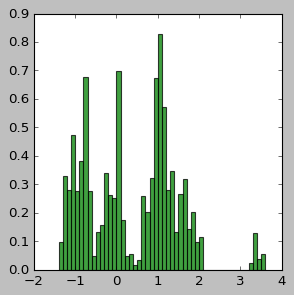

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

Organizando os dados

In [ ]:
# para qualquer previsão futura se faz necessário usar a ordem dos dados especificada como critério de entrada
# pode-se notar pela correlação que os dados de máxima e mínima do pregão anterior possuem alta relação com o preço do fechamento do pregão seguinte
# por isso eles vão ser usados como critério de entrada 
entrada = ['maxima', 'minima']
# saida = ['ultimo']  já que normalizamos os dados de fechamento, então esses não vão ser usados
valor_entrada = dados[entrada]
#valor_saida = dados[saida]
valor_saida = series
# já que normalizamos os dados

In [ ]:
x = valor_entrada
y = valor_saida

Dividindo os dados

In [ ]:
from sklearn.model_selection import train_test_split
#qualquer valor
SEED = 0 

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.30, random_state=SEED)

Aplicando a árvore de decisão

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
def regressor_arvore(nivel):
    SEED= 0
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(max_depth=nivel)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True)
    print(f"Nivel {nivel} | Treino = {(resultados['train_score']*-1).mean()} | Teste = {(resultados['test_score']*-1).mean()}")
    treino.append((resultados['train_score']*-1).mean())
    teste.append((resultados['test_score']*-1).mean())

In [ ]:
iteracoes = []
treino = []
teste = []
for i in range(1,21):
    resultados = regressor_arvore(i)
    iteracoes.append(i)

Nivel 1 | Treino = 0.2840647834167044 | Teste = 0.2844354481640804
Nivel 2 | Treino = 0.08409920556908637 | Teste = 0.08435898206788087
Nivel 3 | Treino = 0.024103992704856025 | Teste = 0.024465813856069475
Nivel 4 | Treino = 0.009155707915418258 | Teste = 0.009651430401272369
Nivel 5 | Treino = 0.003598825455197788 | Teste = 0.005175949751537871
Nivel 6 | Treino = 0.0021427173710066765 | Teste = 0.004201741682421126
Nivel 7 | Treino = 0.001405617215513983 | Teste = 0.004438700530951277
Nivel 8 | Treino = 0.0011132974961981196 | Teste = 0.003598138476174137
Nivel 9 | Treino = 0.0010093677648217035 | Teste = 0.004383025635074567
Nivel 10 | Treino = 0.0009461657756795865 | Teste = 0.004035631222193229
Nivel 11 | Treino = 0.0008895529644705422 | Teste = 0.003732784015805346
Nivel 12 | Treino = 0.0008447890814033441 | Teste = 0.004157274680837908
Nivel 13 | Treino = 0.0008100793145545112 | Teste = 0.004588608234602045
Nivel 14 | Treino = 0.0007857189149087457 | Teste = 0.004209905116638403

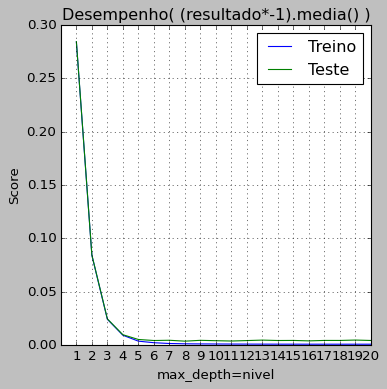

In [ ]:
plt.figure(figsize=(5,5))
plt.plot( iteracoes, treino, 'b-', color='blue', label = 'Treino')
plt.plot( iteracoes, teste, 'b-', color='green', label = 'Teste')
plt.title('Desempenho( (resultado*-1).media() )')
plt.xlabel('max_depth=nivel')
plt.ylabel('Score')
plt.legend()
plt.xticks(iteracoes)
plt.grid('True')
plt.show()

In [ ]:
def calcula_mse(resultados):
    media = (resultados["test_score"]*-1).mean()
    desvio_padrao = (resultados["test_score"]*-1).std()
    lim_inferior = media - (2*desvio_padrao)
    lim_superior = media + (2*desvio_padrao)
    print(f"Intervalo de confiança {lim_inferior} - {lim_superior}")

In [ ]:
SEED= 1232
np.random.seed(SEED)
partes = KFold(n_splits = 10, shuffle=True)
modelo_arvore = DecisionTreeRegressor(max_depth=16) # resgatar a melhor performance
modelo_arvore.fit(x_treino, y_treino) # aprende
predicoes = modelo_arvore.predict(x_teste) #prever
resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error")
calcula_mse(resultados) # para encontrar o intervalo de confiança

Intervalo de confiança -0.004724014361448157 - 0.013679101183504239


NSE = 0.9982288081635043
MAE = 0.023924028417799708


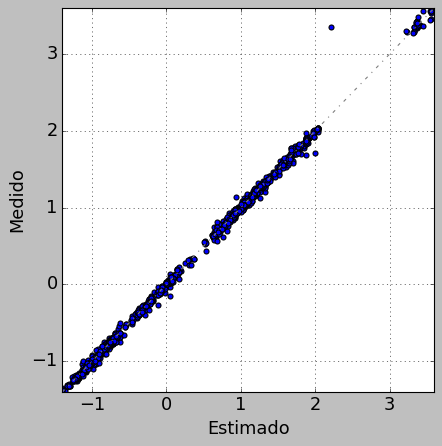

In [ ]:
#predicoes = predicoes.reshape(1404, 1)
Min = series.min()
Max = series.max()
plt.figure(figsize=(6,6))
plt.scatter(predicoes, y_teste)
plt.plot([Min,Max],[Min,Max],'-.', c = 'gray')
plt.ylim([Min,Max])
plt.xlim([Min,Max])
plt.xticks(fontsize = 16)
plt.xlabel("Estimado", fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Medido", fontsize = 16)
plt.grid(True)
def NSE(Yobs, Ysim):
  Yobs_m = np.mean(Yobs)
  s = np.sum((Yobs - Ysim)**2)
  i = np.sum((Yobs - Yobs_m)**2)
  return 1 - s/i
print('NSE =',NSE(y_teste, predicoes))
print('MAE =', tf.keras.metrics.mean_absolute_error(y_teste, predicoes).numpy())

### Analise dos dados da ação PETR4

Importando bibliotecas

In [ ]:
# Iniciando as bibliotecas usadas para montar um sistema de aprendizado de máquina chamado árvore de decisão,
# No qual tem como objetivo criar um "raciocínio" das informações de saída e entrada e fornecer um método no qual seja possível prever informações 
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Os dados foram coletados do site Br investing, teve como critério principal coletar os dados diários entre 01/01/1993 até 01/12/2020
# porém foi possivel encontrar registros até 14/01/2000
# Para o estudo foi IMPORTANTE manipular os dados coletados, primeiro foi mantido a coluna preço e as datas em seu lugar de inicio,
# mas para os demais dados foi selecionado e "rebaixado", para que os dados do dia ficassem a par com as informações de abertura, max, min, vol e var 
# do pregão anterior, ou seja, temos como premissa que o valor de fechamento de hoje será influenciado pelos dados de abertura, max, min, vol e var do pregão anterior
origem = 'drive/My Drive/Artigo_de_economia,_programacao_e_matematica/PETRomosdadoscertosparamanipulacao.csv'
planilha = pd.read_csv(origem, sep=',')
plt.style.use('classic')

In [ ]:
planilha.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,2,4,2013,15.36,15.86,15.95,15.66,15480000,-1.69
1,1,4,2013,15.66,15.98,16.08,15.81,15650000,-0.38
2,28,3,2013,15.93,16.14,16.15,15.93,13170000,-0.87
3,27,3,2013,15.99,16.26,16.39,16.04,15690000,-0.25
4,26,3,2013,16.13,16.26,16.33,15.99,23990000,0.00


In [ ]:
dados = planilha.dropna(axis=0, how='any') # Remover qualquer linhas que possua NaN (células vazias)

In [ ]:
dados.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,2,4,2013,15.36,15.86,15.95,15.66,15480000,-1.69
1,1,4,2013,15.66,15.98,16.08,15.81,15650000,-0.38
2,28,3,2013,15.93,16.14,16.15,15.93,13170000,-0.87
3,27,3,2013,15.99,16.26,16.39,16.04,15690000,-0.25
4,26,3,2013,16.13,16.26,16.33,15.99,23990000,0.00


In [ ]:
dados.shape

(4999, 9)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dia       4999 non-null   int64  
 1   meses     4999 non-null   int64  
 2   anos      4999 non-null   int64  
 3   ultimo    4999 non-null   float64
 4   abertura  4999 non-null   float64
 5   maxima    4999 non-null   float64
 6   minima    4999 non-null   float64
 7   vol       4999 non-null   int64  
 8   var       4999 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 390.5 KB


In [ ]:
dados["var"].value_counts().sort_index()

-33.33     1
-25.00     1
-19.19     1
-18.75     1
-18.73     1
          ..
 23.40     1
 25.00     1
 33.33     2
 50.00     2
 100.00    1
Name: var, Length: 1172, dtype: int64

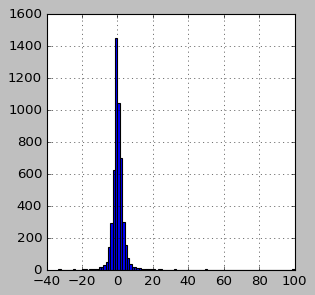

In [ ]:
dados["var"].hist(bins = 100, figsize = (4,4))

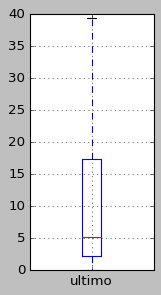

In [ ]:
dados.boxplot(figsize=(2, 4),column=['ultimo'])

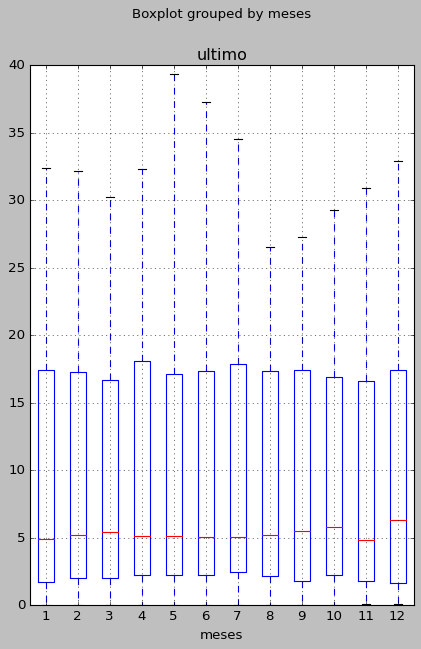

In [ ]:
dados.boxplot(figsize=(6, 9),column=['ultimo'],by = 'meses')

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xticks(fontsize = 16)
    plt.legend()
    plt.xlabel("Time")
    plt.yticks(fontsize = 16)
    plt.ylabel("Value")
    plt.grid(True)    

No handles with labels found to put in legend.


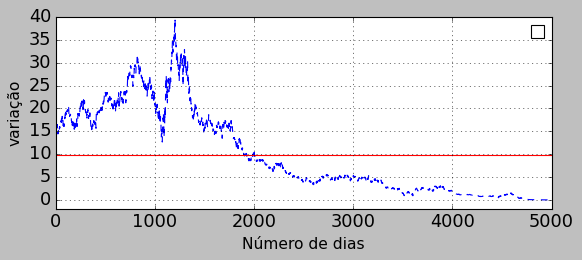

In [ ]:
plt.figure(figsize=(8, 3))
plot_series(np.linspace(1,len(dados),len(dados)),dados.ultimo,'--')
plt.xlabel("Número de dias", fontsize = 14)
plt.ylabel("variação", fontsize = 14)
plt.ylim(-2,)
plt.axhline(y=dados.ultimo.mean(), c = 'r')

In [ ]:
dados["ultimo"].mean() # média simples

9.88694138827767

In [ ]:
dados["ultimo"].std() # Retorna o desvio padrão da amostra sobre o eixo solicitado

9.252406277046578

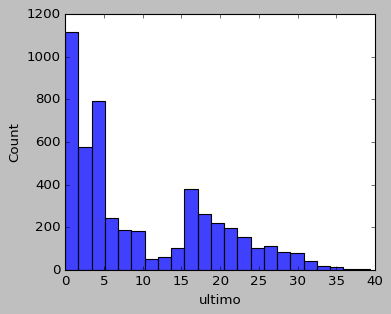

In [ ]:
plt.figure(figsize=(5,4))
sns.histplot(dados, x = "ultimo")

Aplicando o teste de correlação

In [ ]:
dados.columns.values

array(['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima',
       'vol', 'var'], dtype=object)

In [ ]:
dadostestes = ['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima','vol', 'var']
dadostestes = dados[dadostestes]

<Figure size 800x800 with 0 Axes>

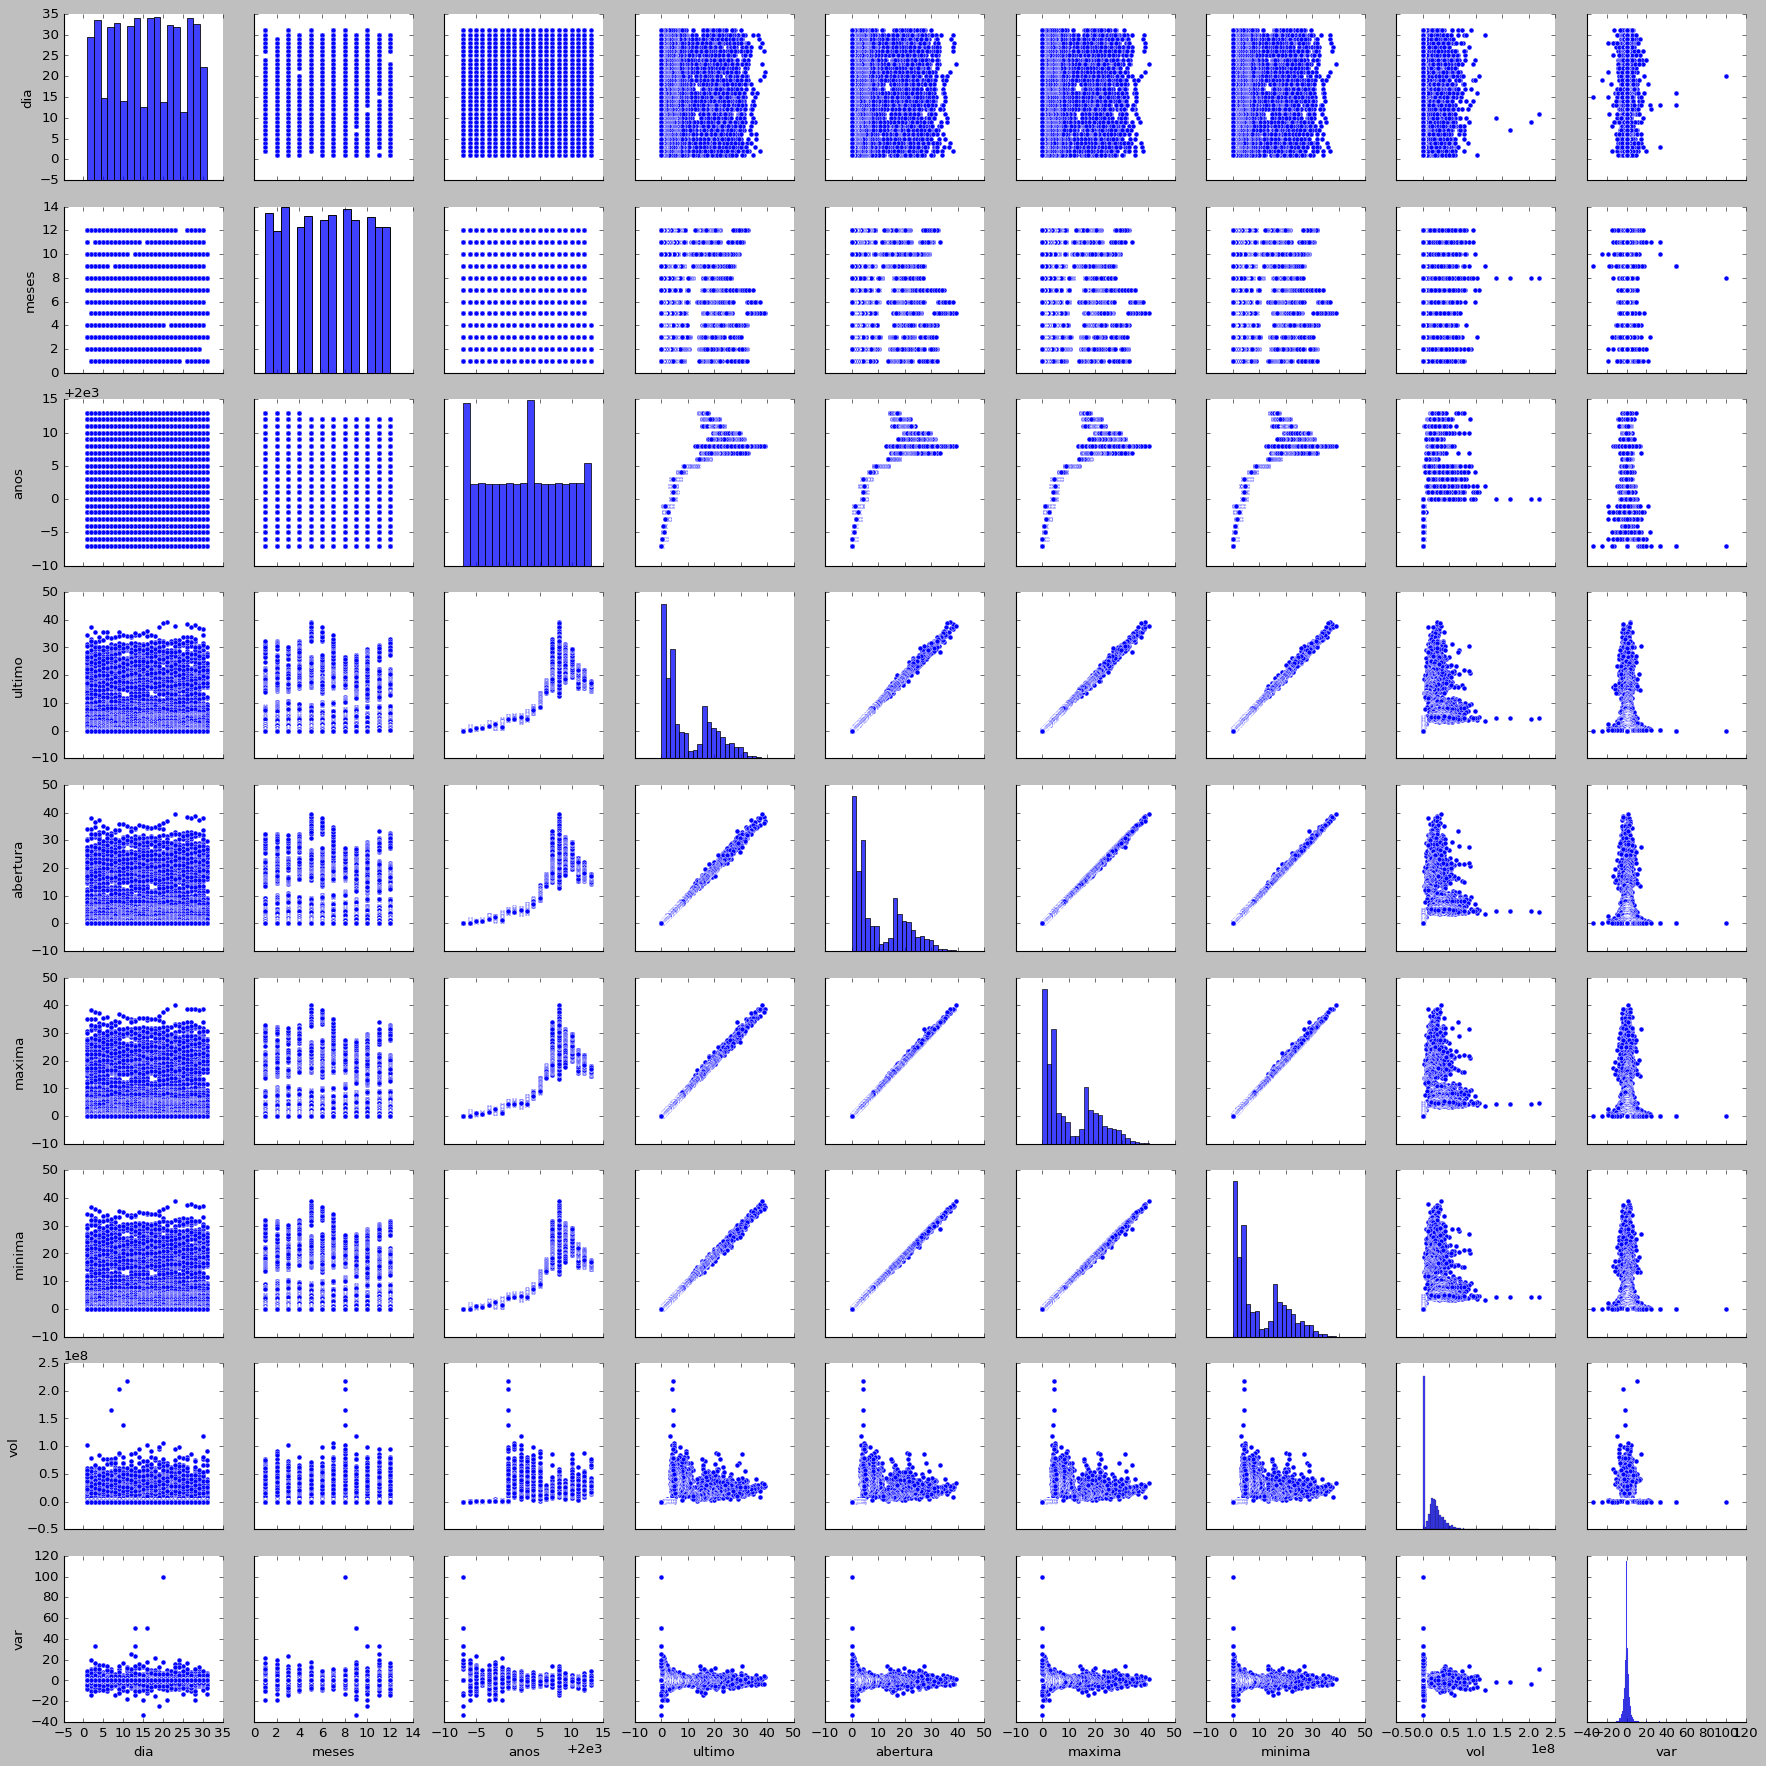

In [ ]:
plt.figure(figsize=(10, 10))
sns.pairplot(dadostestes)

In [ ]:
correlacao = dadostestes.corr()
correlacao

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
dia,1.000000,0.001173,-0.001205,-0.001255,-0.001681,-0.001933,-0.001221,-0.006209,-0.023851
meses,0.001173,1.000000,-0.034452,-0.014878,-0.014964,-0.014309,-0.015725,0.021681,0.001210
anos,-0.001205,-0.034452,1.000000,0.875097,0.874919,0.874593,0.875871,0.477525,-0.059516
ultimo,-0.001255,-0.014878,0.875097,1.000000,0.998907,0.999159,0.999186,0.290301,-0.034029
abertura,-0.001681,-0.014964,0.874919,0.998907,1.000000,0.999818,0.999760,0.289288,-0.047303
maxima,-0.001933,-0.014309,0.874593,0.999159,0.999818,1.000000,0.999681,0.291623,-0.041933
minima,-0.001221,-0.015725,0.875871,0.999186,0.999760,0.999681,1.000000,0.287442,-0.041167
vol,-0.006209,0.021681,0.477525,0.290301,0.289288,0.291623,0.287442,1.000000,-0.026977
var,-0.023851,0.001210,-0.059516,-0.034029,-0.047303,-0.041933,-0.041167,-0.026977,1.000000


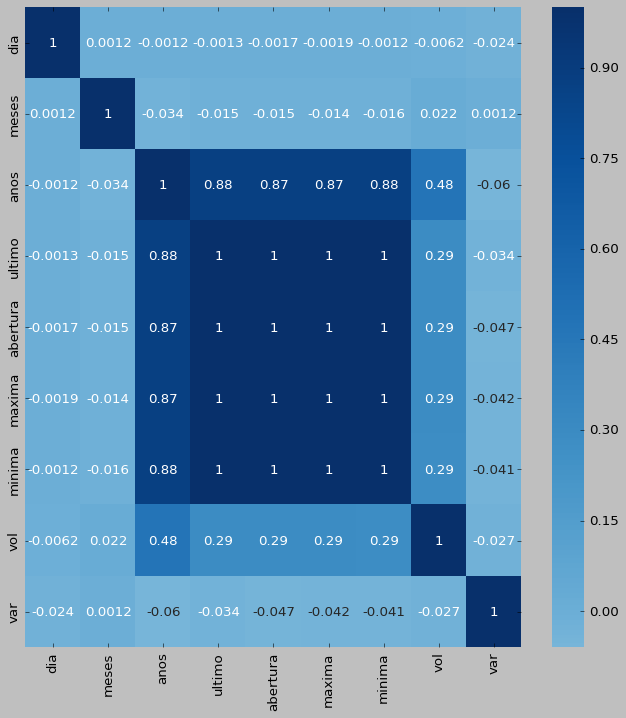

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlacao, cmap="Blues", center=0, annot=True)

Normalizando os dados de fechamento

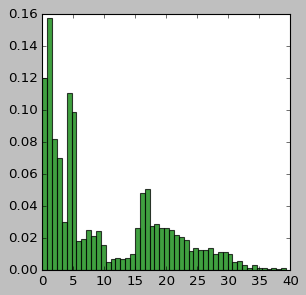

Média dos valores normalizados 2.4719228397368513
Desvio Padrão dos valores normalizados 0.6830654519180853


In [ ]:
series = dados.ultimo
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()
iteração = np.linspace(1,len(dados),len(dados))
percent_train = .7
divisao = int(percent_train*len(dados))
ln_series = np.log(series+1)
x_train = ln_series[:divisao]
xm = x_train.mean()
Sx = x_train.std()
print("Média dos valores normalizados", xm)
print("Desvio Padrão dos valores normalizados",Sx)
series = (ln_series - xm)/Sx

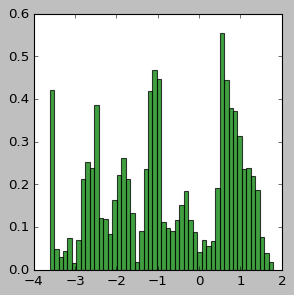

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

Organizando os dados

In [ ]:
# para qualquer previsão futura se faz necessário usar a ordem dos dados especificada como critério de entrada
# pode-se notar pela correção que os dados de máxima, mínima e o preço de abertura do dia anterior possuem alta relação com o preço do pregão seguinte
# por isso eles vão ser usados como critério de entrada 
entrada = ['abertura','maxima', 'minima']
# saida = ['ultimo']  já que normalizamos os dados de fechamento, então esses não vão ser usados
valor_entrada = dados[entrada]
#valor_saida = dados[saida]
valor_saida = series
# já que normalizamos os dados

In [ ]:
x = valor_entrada
y = valor_saida

Dividindo os dados

In [ ]:
from sklearn.model_selection import train_test_split
#qualquer valor
SEED = 0
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.30, random_state=SEED)

Aplicando a árvore de decisão

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
def regressor_arvore(nivel):
    SEED= 0
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(max_depth=nivel)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True)
    print(f"Nivel {nivel} | Treino = {(resultados['train_score']*-1).mean()} | Teste = {(resultados['test_score']*-1).mean()}")
    treino.append((resultados['train_score']*-1).mean())
    teste.append((resultados['test_score']*-1).mean())

In [ ]:
iteracoes = []
treino = []
teste = []
for i in range(1,21):
    resultados = regressor_arvore(i)
    iteracoes.append(i)

Nivel 1 | Treino = 0.5335033466717592 | Teste = 0.533823950387869
Nivel 2 | Treino = 0.1391168316445983 | Teste = 0.13947550302761638
Nivel 3 | Treino = 0.02750167575661703 | Teste = 0.02783488931855732
Nivel 4 | Treino = 0.008588111680879093 | Teste = 0.00895469576196782
Nivel 5 | Treino = 0.002977591429698519 | Teste = 0.003410401953621513
Nivel 6 | Treino = 0.001467025521875302 | Teste = 0.0018823888573293382
Nivel 7 | Treino = 0.0010430893588018054 | Teste = 0.0014891998623772962
Nivel 8 | Treino = 0.0008591104955547929 | Teste = 0.001515083781975911
Nivel 9 | Treino = 0.0006860146636066725 | Teste = 0.0016276419828151283
Nivel 10 | Treino = 0.0005143097301407184 | Teste = 0.0017817042623872608
Nivel 11 | Treino = 0.0003714946368438322 | Teste = 0.0018685199156274154
Nivel 12 | Treino = 0.00025718502627659185 | Teste = 0.001974293519679225
Nivel 13 | Treino = 0.00017143359806283002 | Teste = 0.00204596589036041
Nivel 14 | Treino = 0.00011102637512792279 | Teste = 0.0021108972710874

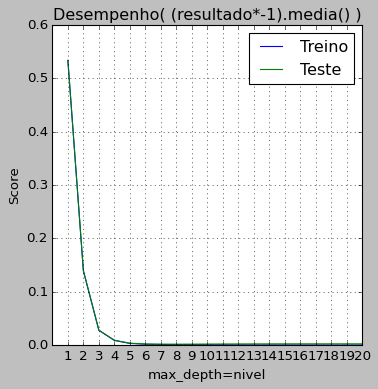

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot( iteracoes, treino, 'b-', color='blue', label = 'Treino')
plt.plot( iteracoes, teste, 'b-', color='green', label = 'Teste')
plt.title('Desempenho( (resultado*-1).media() )')
plt.xlabel('max_depth=nivel')
plt.ylabel('Score')
plt.legend()
plt.xticks(iteracoes)
plt.grid('True')
plt.show()

In [ ]:
def calcula_mse(resultados):
    media = (resultados["test_score"]*-1).mean()
    desvio_padrao = (resultados["test_score"]*-1).std()
    lim_inferior = media - (2*desvio_padrao)
    lim_superior = media + (2*desvio_padrao)
    print(f"Intervalo de confiança {lim_inferior} - {lim_superior}")

In [ ]:
SEED= 1232
np.random.seed(SEED)
partes = KFold(n_splits = 10, shuffle=True)
modelo_arvore = DecisionTreeRegressor(max_depth=20) # resgatar a melhor performance
modelo_arvore.fit(x_treino, y_treino) # aprende
predicoes = modelo_arvore.predict(x_teste) #prever
resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error")
calcula_mse(resultados) # para encontrar o intervalo de confiança

Intervalo de confiança 0.0017984425113838028 - 0.00275004981894018


NSE = 0.9990437266260125
MAE = 0.033202840634631706


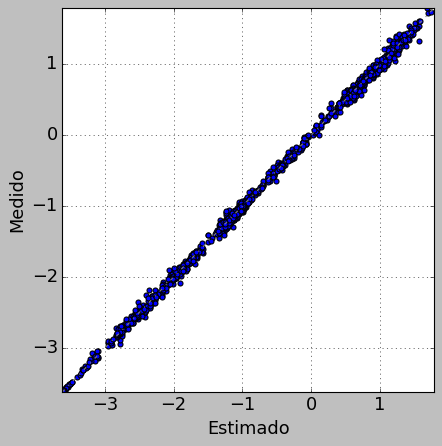

In [ ]:
#predicoes = predicoes.reshape(1404, 1)
Min = series.min()
Max = series.max()
plt.figure(figsize=(6,6))
plt.scatter(predicoes, y_teste)
plt.plot([Min,Max],[Min,Max],'-.', c = 'gray')
plt.ylim([Min,Max])
plt.xlim([Min,Max])
plt.xticks(fontsize = 16)
plt.xlabel("Estimado", fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Medido", fontsize = 16)
plt.grid(True)
def NSE(Yobs, Ysim):
  Yobs_m = np.mean(Yobs)
  s = np.sum((Yobs - Ysim)**2)
  i = np.sum((Yobs - Yobs_m)**2)
  return 1 - s/i
print('NSE =',NSE(y_teste, predicoes))
print('MAE =', tf.keras.metrics.mean_absolute_error(y_teste, predicoes).numpy())

### Analise dos dados da ação VALE3

Importando bibliotecas

In [ ]:
# Iniciando as bibliotecas usadas para montar um sistema de aprendizado de máquina chamado árvore de decisão
# No qual tem como objetivo criar um "raciocínio" das informações de saída e entrada, para poder fornecer um método no qual seja possivel prever informações 
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Os dados foram coletados do site Br investing, teve como critério principal coletar os dados diários entre 01/01/1993 até 01/12/2020
# porém foi possivel encontrar registros até 14/01/2000
# Para o estudo foi IMPORTANTE manipular os dados coletados, primeiro foi mantido a coluna preço e as datas em seu lugar de inicio
# mas para os demais dados foi selecionado e "rebaixado", para que os dados do dia ficassem a par com as informações de abertura, max, min, vol e var 
# do pregão anterior, ou seja, temos como premissa que o valor de fechamento de hoje será influenciado pelos dados de abertura, max, min, vol e var do pregão anterior
origem = 'drive/My Drive/Artigo_de_economia,_programacao_e_matematica/valeomosdadoscertosparamanipulacao.csv'
planilha = pd.read_csv(origem, sep=',')
plt.style.use('classic')

In [ ]:
planilha.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,1,12,2020,81.25,78.86,79.36,77.13,48590000,-0.56
1,30,11,2020,78.00,77.02,78.72,76.81,48970000,2.44
2,27,11,2020,78.44,75.45,76.59,75.45,20360000,1.42
3,26,11,2020,76.57,73.64,75.90,73.64,36270000,0.94
4,25,11,2020,75.50,71.09,74.89,70.18,49910000,4.92


In [ ]:
dados = planilha.dropna(axis=0, how='any') # Remover qualquer linhas que possua NaN (células vazias)

In [ ]:
dados.head()

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
0,1,12,2020,81.25,78.86,79.36,77.13,48590000,-0.56
1,30,11,2020,78.00,77.02,78.72,76.81,48970000,2.44
2,27,11,2020,78.44,75.45,76.59,75.45,20360000,1.42
3,26,11,2020,76.57,73.64,75.90,73.64,36270000,0.94
4,25,11,2020,75.50,71.09,74.89,70.18,49910000,4.92


In [ ]:
dados.shape

(4932, 9)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4932 entries, 0 to 4931
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dia       4932 non-null   int64  
 1   meses     4932 non-null   int64  
 2   anos      4932 non-null   int64  
 3   ultimo    4932 non-null   float64
 4   abertura  4932 non-null   float64
 5   maxima    4932 non-null   float64
 6   minima    4932 non-null   float64
 7   vol       4932 non-null   int64  
 8   var       4932 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 385.3 KB


In [ ]:
dados["var"].value_counts().sort_index()

-24.52    1
-18.57    1
-15.20    1
-14.51    1
-13.23    1
         ..
 14.54    1
 14.76    1
 16.96    1
 18.45    1
 21.36    1
Name: var, Length: 1128, dtype: int64

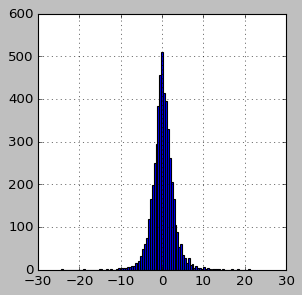

In [ ]:
dados["var"].hist(bins = 100, figsize = (4,4))

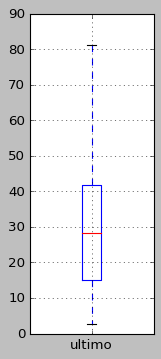

In [ ]:
dados.boxplot(figsize=(2, 5),column=['ultimo'])

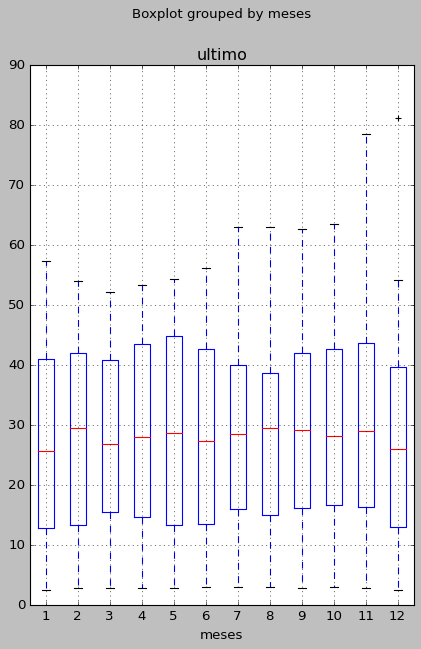

In [ ]:
dados.boxplot(figsize=(6, 9),column=['ultimo'],by = 'meses')

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xticks(fontsize = 16)
    plt.legend()
    plt.xlabel("Time")
    plt.yticks(fontsize = 16)
    plt.ylabel("Value")
    plt.grid(True)    

No handles with labels found to put in legend.


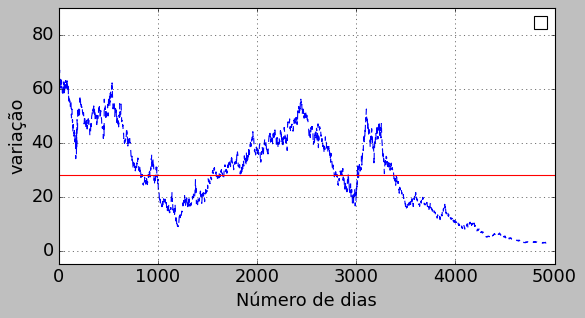

In [ ]:
plt.figure(figsize=(8, 4))
plot_series(np.linspace(1,len(dados),len(dados)),dados.ultimo,'--')
plt.xlabel("Número de dias", fontsize = 16)
plt.ylabel("variação", fontsize = 16)
plt.ylim(-5,)
plt.axhline(y=dados.ultimo.mean(), c = 'r')

In [ ]:
dados["ultimo"].mean() # média simples

28.04526155717751

In [ ]:
dados["ultimo"].std() # Retorna o desvio padrão da amostra sobre o eixo solicitado

16.199814260201098

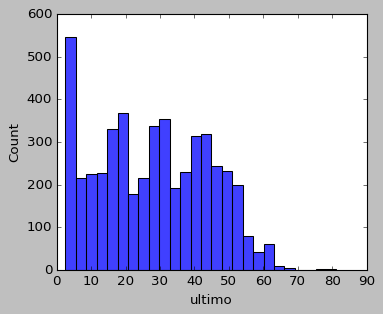

In [ ]:
plt.figure(figsize=(5,4))
sns.histplot(dados, x = "ultimo")

Aplicando o teste de correlação

In [ ]:
dados.columns.values

array(['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima',
       'vol', 'var'], dtype=object)

In [ ]:
dadostestes = ['dia', 'meses', 'anos', 'ultimo', 'abertura', 'maxima', 'minima','vol', 'var']
dadostestes = dados[dadostestes]

<Figure size 800x800 with 0 Axes>

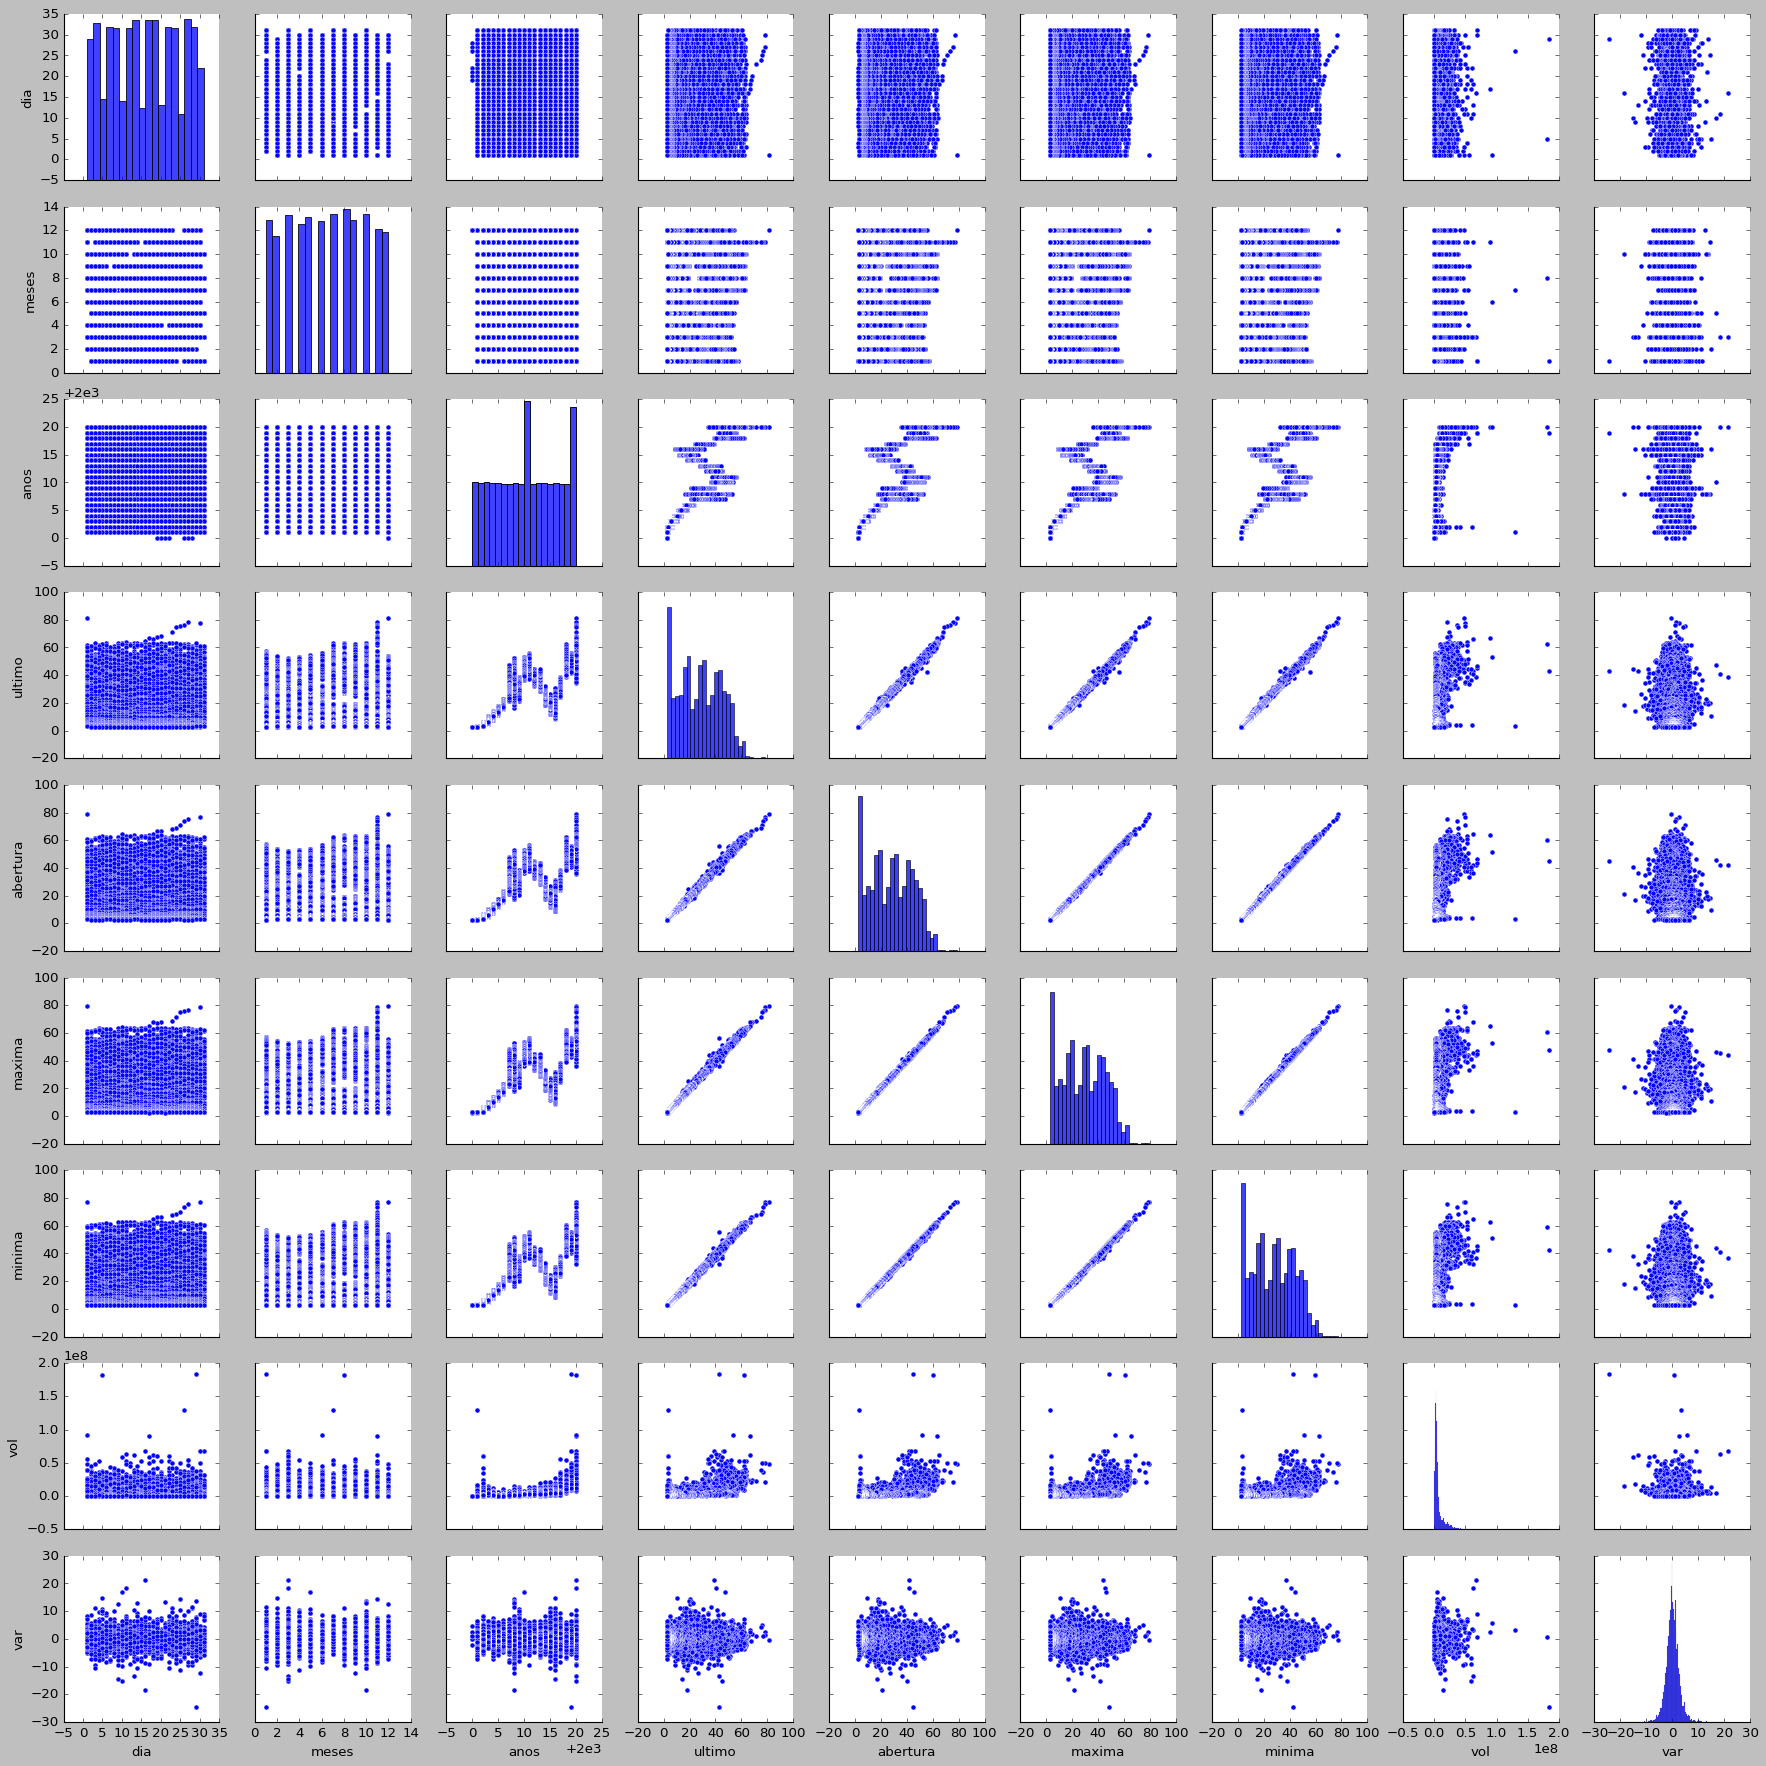

In [ ]:
plt.figure(figsize=(10, 10))
sns.pairplot(dadostestes)

In [ ]:
correlacao = dadostestes.corr()
correlacao

,dia,meses,anos,ultimo,abertura,maxima,minima,vol,var
dia,1.000000,-0.001725,0.000316,0.004128,0.004408,0.004031,0.004565,-0.004635,-0.008091
meses,-0.001725,1.000000,-0.017037,0.027203,0.026285,0.025568,0.026905,0.002404,0.015156
anos,0.000316,-0.017037,1.000000,0.706787,0.706968,0.709012,0.705577,0.570976,-0.009242
ultimo,0.004128,0.027203,0.706787,1.000000,0.998096,0.998490,0.998522,0.429793,0.010457
abertura,0.004408,0.026285,0.706968,0.998096,1.000000,0.999688,0.999643,0.427727,-0.016391
maxima,0.004031,0.025568,0.709012,0.998490,0.999688,1.000000,0.999562,0.432610,-0.003737
minima,0.004565,0.026905,0.705577,0.998522,0.999643,0.999562,1.000000,0.424193,-0.002474
vol,-0.004635,0.002404,0.570976,0.429793,0.427727,0.432610,0.424193,1.000000,0.004243
var,-0.008091,0.015156,-0.009242,0.010457,-0.016391,-0.003737,-0.002474,0.004243,1.000000


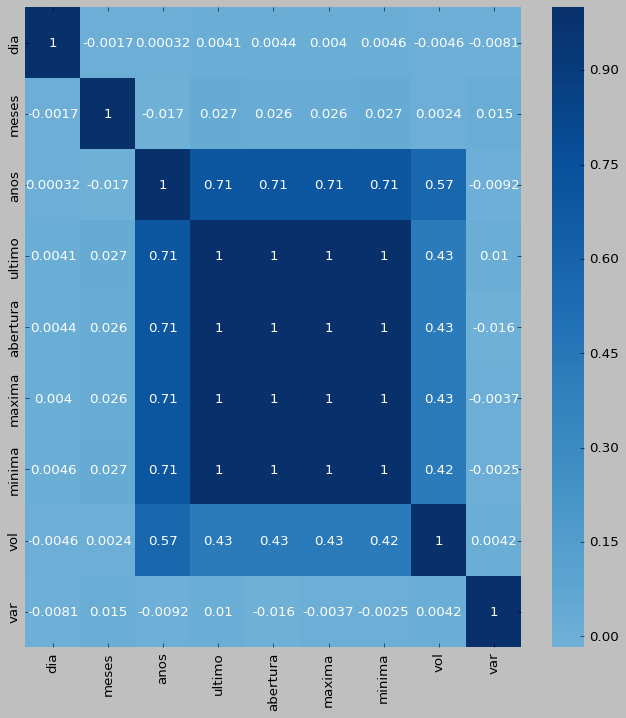

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlacao, cmap="Blues", center=0, annot=True)

Normalizando os dados de fechamento

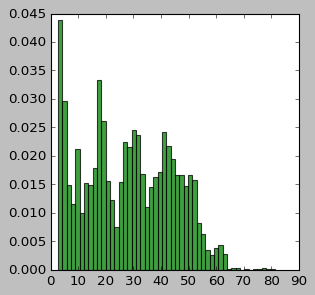

Média dos valores normalizados 3.5496059399047626
Desvio Padrão dos valores normalizados 0.3670906542780424


In [ ]:
series = dados.ultimo
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()
iteração = np.linspace(1,len(dados),len(dados))
percent_train = .7
divisao = int(percent_train*len(dados))
ln_series = np.log(series+1)
x_train = ln_series[:divisao]
xm = x_train.mean()
Sx = x_train.std()
print("Média dos valores normalizados", xm)
print("Desvio Padrão dos valores normalizados",Sx)
series = (ln_series - xm)/Sx

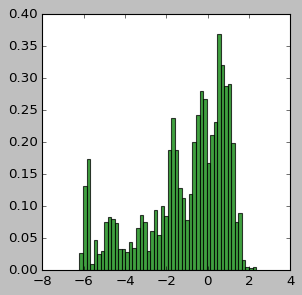

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

Organizando os dados

In [ ]:
# para qualquer previsão futura se faz necessário usar a ordem dos dados especificada como critério de entrada
# pode-se notar pela correção que os dados de máxima, mínima e de abertura do pregão anterior possuem alta relação com o preço do pregão seguinte
# por isso eles vão ser usados como critério de entrada 
entrada = ['abertura','maxima', 'minima']
# saida = ['ultimo']  #já que normalizamos os dados de fechamento, então esses não vão ser usados
valor_entrada = dados[entrada]
#valor_saida = dados[saida]
valor_saida = series
# já que normalizamos os dados

In [ ]:
x = valor_entrada
y = valor_saida

Dividindo os dados

In [ ]:
from sklearn.model_selection import train_test_split
#qualquer valor
SEED = 0
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.30, random_state=SEED)

Aplicando a árvore de decisão

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
def regressor_arvore(nivel):
    SEED= 0
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(max_depth=nivel)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True)
    print(f"Nivel {nivel} | Treino = {(resultados['train_score']*-1).mean()} | Teste = {(resultados['test_score']*-1).mean()}")
    treino.append((resultados['train_score']*-1).mean())
    teste.append((resultados['test_score']*-1).mean())

In [ ]:
iteracoes = []
treino = []
teste = []
for i in range(1,21):
    resultados = regressor_arvore(i)
    iteracoes.append(i)

Nivel 1 | Treino = 1.1655578598671317 | Teste = 1.1692479811414505
Nivel 2 | Treino = 0.29766139390962754 | Teste = 0.29964095030359683
Nivel 3 | Treino = 0.0728921626764287 | Teste = 0.07397453800769668
Nivel 4 | Treino = 0.02449092692303486 | Teste = 0.026124889855688404
Nivel 5 | Treino = 0.009587029205295538 | Teste = 0.011251869041794284
Nivel 6 | Treino = 0.005864163337149142 | Teste = 0.0075573503873331786
Nivel 7 | Treino = 0.004727787853445046 | Teste = 0.006798433219822089
Nivel 8 | Treino = 0.003923323796289438 | Teste = 0.007152680220009189
Nivel 9 | Treino = 0.003118991908512088 | Teste = 0.007562453189410043
Nivel 10 | Treino = 0.0024426777184336245 | Teste = 0.008235603666539661
Nivel 11 | Treino = 0.0018195489240845624 | Teste = 0.00891604127479312
Nivel 12 | Treino = 0.0012857891824628873 | Teste = 0.009480358248633539
Nivel 13 | Treino = 0.0008579004735384324 | Teste = 0.009885814628195837
Nivel 14 | Treino = 0.0005471695331012657 | Teste = 0.010332032677629504
Nivel 

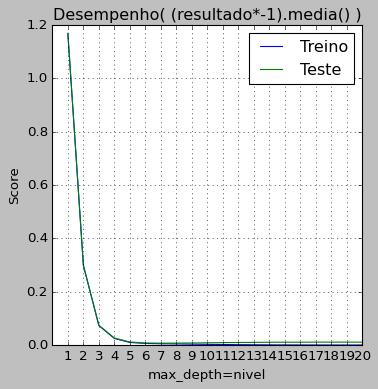

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot( iteracoes, treino, 'b-', color='blue', label = 'Treino')
plt.plot( iteracoes, teste, 'b-', color='green', label = 'Teste')
plt.title('Desempenho( (resultado*-1).media() )')
plt.xlabel('max_depth=nivel')
plt.ylabel('Score')
plt.legend()
plt.xticks(iteracoes)
plt.grid('True')
plt.show()

In [ ]:
def calcula_mse(resultados):
    media = (resultados["test_score"]*-1).mean()
    desvio_padrao = (resultados["test_score"]*-1).std()
    lim_inferior = media - (2*desvio_padrao)
    lim_superior = media + (2*desvio_padrao)
    print(f"Intervalo de confiança {lim_inferior} - {lim_superior}")

In [ ]:
SEED= 1232
np.random.seed(SEED)
partes = KFold(n_splits = 10, shuffle=True)
modelo_arvore = DecisionTreeRegressor(max_depth=7) # resgatar a melhor performance
modelo_arvore.fit(x_treino, y_treino) # aprende
predicoes = modelo_arvore.predict(x_teste) #prever
resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error")
calcula_mse(resultados) # para encontrar o intervalo de confiança

Intervalo de confiança 0.0050752121809070705 - 0.00830506925607444


NSE = 0.9982942985153711
MAE = 0.06205822869270638


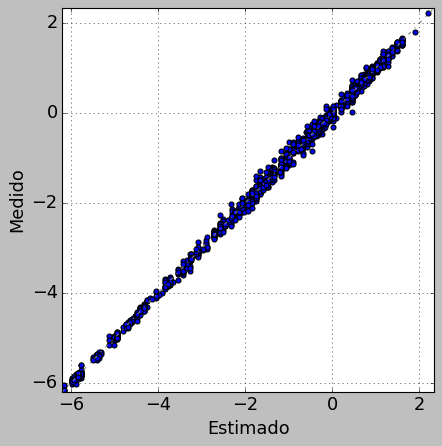

In [ ]:
#predicoes = predicoes.reshape(1404, 1)
Min = series.min()
Max = series.max()
plt.figure(figsize=(6,6))
plt.scatter(predicoes, y_teste)
plt.plot([Min,Max],[Min,Max],'-.', c = 'gray')
plt.ylim([Min,Max])
plt.xlim([Min,Max])
plt.xticks(fontsize = 16)
plt.xlabel("Estimado", fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Medido", fontsize = 16)
plt.grid(True)
def NSE(Yobs, Ysim):
  Yobs_m = np.mean(Yobs)
  s = np.sum((Yobs - Ysim)**2)
  i = np.sum((Yobs - Yobs_m)**2)
  return 1 - s/i
print('NSE =',NSE(y_teste, predicoes))
print('MAE =', tf.keras.metrics.mean_absolute_error(y_teste, predicoes).numpy())